<a href="https://colab.research.google.com/github/Randasabag/Optimisez-la-gestion-des-donn-es-d-une-boutique-avec-R-ou-Python/blob/main/P5_alsabbagh_Optimisation_donnees_boutique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# OPTIMISATION DE LA GESTION DES DONNEES D'UNE BOUTIQUE AVEC PYTHON 

## <font color='indianred'> BOTTLENECK, MARCHAND DE VIN TRÈS PRESTIGIEUX</font>

# Mission :
<ol>
    <li>Rapprochement de deux exports : </li>
   <ul>
        <li> un <b>export de l’ERP</b> contenant les références produit, leur prix de vente et leur état de stock</li>
    <li> un <b>export d’une table de l’outil de CMS</b> contenant les informations des produits commercialisés en ligne (nom, description, nombre de ventes...)</li>
    </ul>
  
  L’export issu de la boutique en ligne contient le nombre de ventes pour chaque produit depuis sa mise en ligne, il ne permet pas d’analyser l'évolution des ventes dans le temps.
    
Un tableau Excel a été créé  afin d’établir le lien entre la référence du produit dans l’ERP (product_id) et la référence du même produit dans la base de la boutique en ligne (SKU). 

  <li> Après le rapprochement effectué, il faut obtenir : 
       <ul><li> le chiffre d’affaires par produit</li>
           <li> le total du chiffre d’affaires réalisé en ligne.</li>
      </ul>    
  </li> <br>

       
   <li> Il y a des erreurs de saisie dans certains prix des produits. Il faudrait effectuer une analyse sur cette variable afin de détecter d’éventuelles valeurs aberrantes, de les lister et d’en faire une représentation graphique pour plus de lisibilité.</li><br>

   <li> Une colonne a été mal nommée dans le fichier Excel. En fait, la colonne id_web dans le fichier correspond au SKU des produits dans la boutique en ligne.</li>   
 </ol>


# Sommaire :
**Partie 1 : Importation des données**
 - <a href="#C1">Importation des librairies</a>
 - <a href="#C2">Importation des jeux de données</a>
 
**Partie 2 : Analyse des jeux de données**
 - <a href="#C3">Affichage du nombre de lignes et colonnes des jeux de données </a>
 - <a href="#C4">Analyse des valeurs manquantes</a>
 - <a href="#C5">Analyse des types de données</a>
 
**Partie 3 : Nettoyage du jeu de données**
 - <a href="#C6">Unicité de la clé primaire</a>
 - <a href="#C7">Suppression des doublons</a>
 - <a href="#C8">Suppression des colonnes vides</a> 
  
**Partie 4 : Rapprochement des exports**
 - <a href="#C9">Renommage de la colonne id_web</a>
 - <a href="#C10">Jointure entre les 3 tables</a>
 
**Partie 5 : Chiffre d'affaires**
 - <a href="#C11">Calcul du CA par produit et le CA total en ligne</a>
 
**Partie 6 : Outliers**
 - <a href="#C12">Detection des outliers par la méthode du Z-score</a>
 - <a href="#C13">Detection des outliers par la méthode du IQR</a>
 - <a href="#C14">Visualisation graphique des outliers</a>

#<font color='indianred'>Partie 1 : Importation des données</font>

# <a name="C1"><font color='LightSeaGreen'>Importation des librairies</font></a>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as st

import io
from google.colab import files

# <a name="C2"><font color='LightSeaGreen'>Importation des jeux de données : erp, liaison et web</font></a>

In [8]:
#Ouvre les fichiers excel
!pip install openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
uploaded = files.upload()

Saving erp.xlsx to erp (2).xlsx
Saving liaison.xlsx to liaison (1).xlsx
Saving web.xlsx to web (1).xlsx


In [14]:
#importe les fichiers excel des données 
df_erp=pd.read_excel(io.BytesIO(uploaded['erp.xlsx']))
pd.set_option('display.max_columns',None)
df_erp.head()

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,product_id,onsale_web,price,stock_quantity,stock_status
0,3847,1,24.2,0,outofstock
1,3849,1,34.3,0,outofstock
2,3850,1,20.8,0,outofstock
3,4032,1,14.1,0,outofstock
4,4039,1,46.0,0,outofstock


In [15]:
df_liaison=pd.read_excel(io.BytesIO(uploaded['liaison.xlsx']))
df_liaison.head()

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,product_id,id_web
0,3847,15298
1,3849,15296
2,3850,15300
3,4032,19814
4,4039,19815


In [16]:
df_web=pd.read_excel(io.BytesIO(uploaded['web.xlsx']))
pd.set_option('display.max_columns', 28)
df_web.head()

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,post_date_gmt,post_content,post_title,post_excerpt,post_status,comment_status,ping_status,post_password,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,2018-06-01 11:53:46,NaN,Bon cadeau de 25€,"<span style=""color: #a85253;""><strong>Parlons ...",publish,closed,closed,NaN,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,2018-02-08 11:58:52,NaN,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",publish,closed,closed,NaN,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,2018-02-08 12:49:41,NaN,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,publish,closed,closed,NaN,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,15300,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,2018-02-08 13:08:36,NaN,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",publish,closed,closed,NaN,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,19814,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,2018-02-09 13:01:05,NaN,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,Gamine représente tout le fruité et la gourman...,publish,closed,closed,NaN,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


# <a name="C3"><font color='indianred'>Partie 2 : Analyse des jeux de données</font></a>

# <a name="C3"><font color='LightSeaGreen'>Affichage du nombre de lignes et colonnes des jeux de données</font></a>

In [17]:
#nombre de lignes et colonnes
print('erp',df_erp.shape)
print('liaison',df_liaison.shape)
print('web',df_web.shape)

erp (825, 5)
liaison (825, 2)
web (1513, 28)


# <a name="C4"><font color='LightSeaGreen'>Analyse des valeurs manquantes</font></a>

In [18]:
#Création d'une fonction calculant le pourcentage de valeurs manquantes 
#et affichant une heatmap pour visualiser les valeurs manquantes 
def val_manq(df):
    ligne,colonne=df.shape
    nb_cell=ligne*colonne
    nb_null=df.isnull().sum().sum()
    prct=nb_null *100/nb_cell
    print('Nombre de valeurs manquantes =',nb_null)
    print('Nombre de cellulles totales =',nb_cell)
    print('Pourcentage de valeurs manquantes = ',round(prct,2),'%') 
    print('\n')
    print('Pourcentage de valeurs manquantes avec le nombre de colonnes =\n',round((df.isna().sum()*100/df.shape[0]),2).value_counts(ascending=True))
    #Calcul des pourcentages de valeurs manquantes par variable(colonne)
    print('\n')
    print('Pourcentage de valeurs manquantes par variable/colonne =\n', 
          round((df.isna().sum()*100/df.shape[0]),2).sort_values(ascending=True))
    print('\n')
    plt.figure(figsize=(6,4))
    sns.heatmap(df.isna(), cbar=False)

1-Table erp :
Nombre de valeurs manquantes = 0
Nombre de cellulles totales = 4125
Pourcentage de valeurs manquantes =  0.0 %


Pourcentage de valeurs manquantes avec le nombre de colonnes =
 0.0    5
dtype: int64


Pourcentage de valeurs manquantes par variable/colonne =
 product_id        0.0
onsale_web        0.0
price             0.0
stock_quantity    0.0
stock_status      0.0
dtype: float64


---------------------------------------
2-Table liaison :
Nombre de valeurs manquantes = 91
Nombre de cellulles totales = 1650
Pourcentage de valeurs manquantes =  5.52 %


Pourcentage de valeurs manquantes avec le nombre de colonnes =
 0.00     1
11.03    1
dtype: int64


Pourcentage de valeurs manquantes par variable/colonne =
 product_id     0.00
id_web        11.03
dtype: float64


---------------------------------------
3-Table web :
Nombre de valeurs manquantes = 9941
Nombre de cellulles totales = 42364
Pourcentage de valeurs manquantes =  23.47 %


Pourcentage de valeurs manquantes avec

Text(0.5, 1.0, 'Heatmap des valeurs manquantes web')

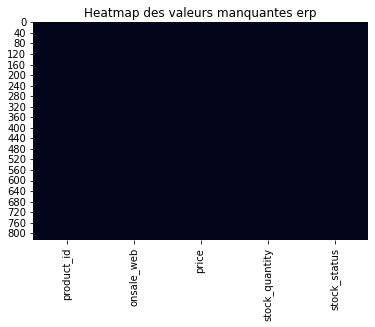

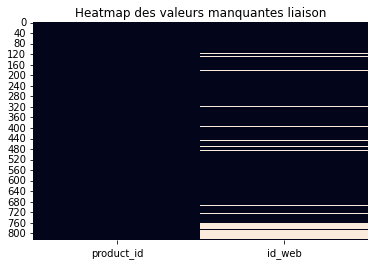

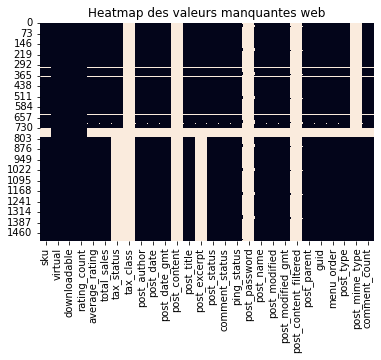

In [19]:
#Appel de la fonction val_manq 
#Affichage des pourcentages de valeurs manquantes des 3 jeux de données 
print('1-Table erp :')
val_manq(df_erp)
plt.title("Heatmap des valeurs manquantes erp")
print('---------------------------------------')
print('2-Table liaison :')
val_manq(df_liaison)
plt.title("Heatmap des valeurs manquantes liaison")
print('---------------------------------------')
print('3-Table web :')
val_manq(df_web)
plt.title("Heatmap des valeurs manquantes web")

Analyse des valeurs manquantes:
1. df_erp : il n'y a pas de valeurs manquantes
2. df_liaison : la colonne id_web contient 11% de valeurs manquantes

3. df_web : il y a 24% de valeurs manquantes
* 4 colonnes vides (100%)
* 3 colonnes sans valeurs manquantes (0%)
* 18 colonnes avec 5% de valeurs manquantes
* 3 colonnes avec 50% de valeurs manquantes


# <a name="C5"><font color='LightSeaGreen'>Analyse des types de données</font></a>

In [20]:
#type des variables de la table erp
print(df_erp.dtypes)
print('\n')
#compte le nombre de variables par type
df_erp.dtypes.value_counts()

product_id          int64
onsale_web          int64
price             float64
stock_quantity      int64
stock_status       object
dtype: object




int64      3
float64    1
object     1
dtype: int64

In [21]:
#type des variables de la table liaison
print(df_liaison.dtypes)
print('\n')
#compte le nombre de variables par type
df_liaison.dtypes.value_counts()

product_id     int64
id_web        object
dtype: object




int64     1
object    1
dtype: int64

In [22]:
#type des variables de la table web
print(df_web.dtypes)
print('\n')
#compte le nombre de variables par type
df_web.dtypes.value_counts()

sku                              object
virtual                           int64
downloadable                      int64
rating_count                      int64
average_rating                  float64
total_sales                     float64
tax_status                       object
tax_class                       float64
post_author                     float64
post_date                datetime64[ns]
post_date_gmt            datetime64[ns]
post_content                    float64
post_title                       object
post_excerpt                     object
post_status                      object
comment_status                   object
ping_status                      object
post_password                   float64
post_name                        object
post_modified            datetime64[ns]
post_modified_gmt        datetime64[ns]
post_content_filtered           float64
post_parent                     float64
guid                             object
menu_order                      float64


object            11
float64           10
datetime64[ns]     4
int64              3
dtype: int64

# <a name="C3"><font color='indianred'>Partie 3 : Nettoyage du jeu de données</font></a>

# <a name="C6"><font color='LightSeaGreen'>Unicité de la clé primaire</font></a>

In [23]:
#Creation d'une fonction qui teste l'unicité d'une colonne
def cle_primaire(df,col):
    if len(df)==len(df[col].unique()):
        print('La variable', col, 'est une clé primaire')
    else: 
        print('La variable', col, 'n\'est pas une clé primaire')

In [24]:
cle_primaire(df_erp,'product_id')
cle_primaire(df_web,'sku')

La variable product_id est une clé primaire
La variable sku n'est pas une clé primaire


In [25]:
#affiche le df dont le sku est null i.e qui n'ont pas de reference produit
df_websku = df_web[df_web['sku'].isnull()]
df_websku

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,post_date_gmt,post_content,post_title,post_excerpt,post_status,comment_status,ping_status,post_password,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
178,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
793,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
795,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Il y a 85 lignes sans sku.

In [26]:
#affiche le df des produits qui ont un nom mais qui n'ont pas de reference produit (sku)
df_webskunotnull = df_websku[df_websku['post_name'].notnull()]
df_webskunotnull

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,post_date_gmt,post_content,post_title,post_excerpt,post_status,comment_status,ping_status,post_password,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
470,NaN,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-07-31 12:07:23,2018-07-31 10:07:23,NaN,Pierre Jean Villa Côte Rôtie Fongeant 2017,"Fongeant 2017 explose sur un fruit brillant, p...",publish,closed,closed,NaN,pierre-jean-villa-cote-rotie-fongeant-2017,2019-11-02 13:24:15,2019-11-02 12:24:15,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
471,NaN,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-08-08 11:23:43,2018-08-08 09:23:43,NaN,Pierre Jean Villa Condrieu Jardin Suspendu 2018,"<span id=""u1194-83"">Le nez séduit par ses parf...",publish,closed,closed,NaN,pierre-jean-villa-condrieu-suspendu-2018,2019-11-02 13:24:01,2019-11-02 12:24:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


Deux produits n'ont pas de sku.


# <a name="C7"><font color='LightSeaGreen'>Suppression des doublons</font></a>

In [27]:
#Copie du dataframe web
df_web_db=df_web.copy()

### Création d'une fonction qui détecte les doublons

In [53]:
#Fonction qui detecte les doublons
def detect_doublons(df):
    doub=df[df.duplicated()]
    print('------------------') 
    print('La table contient', len(doub), 'doublons.')
    print(doub.shape)
    print('\n') 
    print(doub)
    print('\n')

In [54]:
print('------------------') 
print('Table erp')
detect_doublons(df_erp)
print('------------------') 
print('Table liaison')
detect_doublons(df_liaison)
print('------------------') 
print('Table web')
detect_doublons(df_web_db)

------------------
Table erp
------------------
La table contient 0 doublons.
(0, 5)


Empty DataFrame
Columns: [product_id, onsale_web, price, stock_quantity, stock_status]
Index: []


------------------
Table liaison
------------------
La table contient 0 doublons.
(0, 2)


Empty DataFrame
Columns: [product_id, sku]
Index: []


------------------
Table web
------------------
La table contient 82 doublons.
(82, 28)


     sku  virtual  downloadable  rating_count  average_rating  total_sales  \
179  NaN        0             0             0             NaN          NaN   
227  NaN        0             0             0             NaN          NaN   
230  NaN        0             0             0             NaN          NaN   
231  NaN        0             0             0             NaN          NaN   
233  NaN        0             0             0             NaN          NaN   
..   ...      ...           ...           ...             ...          ...   
792  NaN        0             0 

### Création d'une fonction qui supprime les doublons 


In [30]:
#Création d'une fonction qui supprime les doublons et affiche la nouvelle heatmap sans les doublons
def supp_lignes(df):
    df=df.drop_duplicates(keep=False)
    print(df.shape)
    #print('Apres suppression des doublons, nous avons la heatmap suivante:')
    plt.figure(figsize=(6,4))
    sns.heatmap(df.isna(), cbar=False)    

Table erp
(825, 5)
Table liaison
(825, 2)
Table web
(1430, 28)


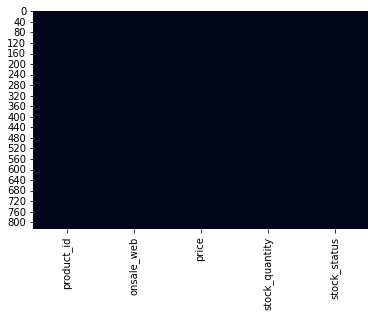

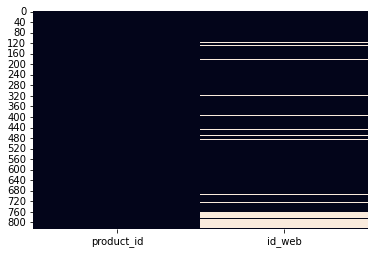

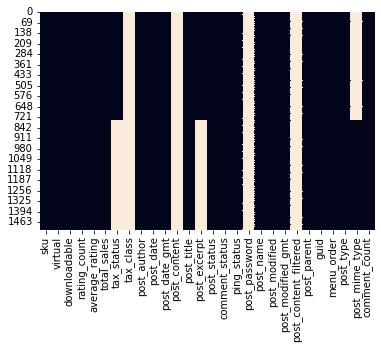

In [31]:
print('Table erp')
supp_lignes(df_erp)
print('Table liaison')
supp_lignes(df_liaison)
print('Table web')
supp_lignes(df_web_db)

In [32]:
#Création du nouveau dataframe web contenant les lignes avec la valeur 'taxable' qui correspond au post du produit 
#alors que la 2eme ligne du meme produit correspond à la pièce jointe du post
df_webtax=df_web_db[(df_web_db['tax_status']=='taxable')&df_web_db['sku'].notnull()]
df_webtax.head()

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,post_date_gmt,post_content,post_title,post_excerpt,post_status,comment_status,ping_status,post_password,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,2018-06-01 11:53:46,NaN,Bon cadeau de 25€,"<span style=""color: #a85253;""><strong>Parlons ...",publish,closed,closed,NaN,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,2018-02-08 11:58:52,NaN,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",publish,closed,closed,NaN,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,2018-02-08 12:49:41,NaN,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,publish,closed,closed,NaN,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,15300,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,2018-02-08 13:08:36,NaN,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",publish,closed,closed,NaN,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,19814,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,2018-02-09 13:01:05,NaN,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,Gamine représente tout le fruité et la gourman...,publish,closed,closed,NaN,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


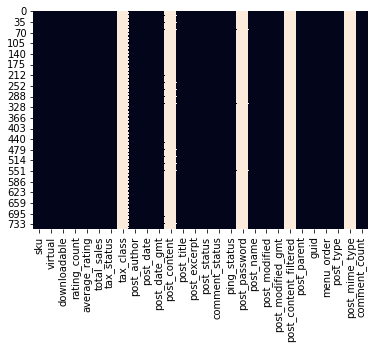

In [33]:
#1nouvelle heatmap du df web sans les lignes en double et les lignes des pieces jointes
sns.heatmap(df_webtax.isna(), cbar=False) 

# <a name="C8"><font color='LightSeaGreen'>Suppression des colonnes vides</font></a>

In [34]:
#affiche la liste des colonnes vides du df web
#les 2 autres df erp et liaison n'ont pas de colonnes vides
print('Liste des colonnes vides:')
[col for col in df_webtax.columns if df_webtax[col].isnull().all()]

Liste des colonnes vides:


['tax_class',
 'post_content',
 'post_password',
 'post_content_filtered',
 'post_mime_type']

### Création d'une fonction qui supprime les colonnes vides

In [35]:
#fonction qui compte, supprime les colonnes vides et affiche la nouvelle heatmap
def colonnes_vides(df): 
    l=[col for col in df.columns if df[col].isnull().all()]
    print('Nombre de colonnes vides =',len(l))
    for cv in l:
        df.pop(cv)
    print(df.shape)
    plt.figure(figsize=(6,4))
    sns.heatmap(df.isna(), cbar=False)

Nombre de colonnes vides = 5
(714, 23)


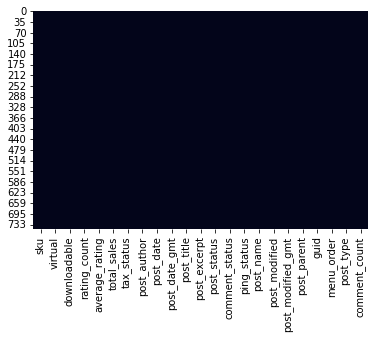

In [36]:
#utilisation de la fonction qui compte et supprime les colonnes vides
colonnes_vides(df_webtax)

# <a name="C4"><font color='indianred'>Partie 4 : Rapprochement des exports</font></a>

# <a name="C9"><font color='LightSeaGreen'>Renommage de la colonne id_web</font></a>

In [37]:
#Renommage de la colonne id_web de la table liaison correspondant à 'sku' dans la table web
df_liaison=df_liaison.rename(columns={'id_web':'sku'})
df_liaison.head(2)

,product_id,sku
0,3847,15298
1,3849,15296


# <a name="C10"><font color='LightSeaGreen'>Jointure des 3 tables</font></a>

## Jointure complète 

In [38]:
#Jointure des 2 dataframes erp et liaison en faisant l'union complète 
df_erp_liaison=pd.merge(df_erp, df_liaison, left_on='product_id', right_on='product_id', how='outer')          
df_erp_liaison

,product_id,onsale_web,price,stock_quantity,stock_status,sku
0,3847,1,24.2,0,outofstock,15298
1,3849,1,34.3,0,outofstock,15296
2,3850,1,20.8,0,outofstock,15300
3,4032,1,14.1,0,outofstock,19814
4,4039,1,46.0,0,outofstock,19815
...,...,...,...,...,...,...
820,7203,0,45.0,30,instock,NaN
821,7204,0,45.0,9,instock,NaN
822,7247,1,54.8,23,instock,13127-1
823,7329,0,26.5,14,instock,14680-1


In [39]:
#Jointure des 2 dataframes erp_liaison et web en faisant l'union complète avec un indicateur 
#qui montre si la ligne appartient à df1 ou df2
#une colonne _merge se crée et indique both si la ligne appartient aux 2 df, 
#left_only si la ligne appartient au df de gauche
#Cette jointure lie toutes les lignes remplissant les cellules vides par une valeur nulle
df_final_outer=pd.merge(df_erp_liaison, df_webtax, left_on='sku', right_on='sku', how='outer', indicator=True)
df_final_outer.head()

,product_id,onsale_web,price,stock_quantity,stock_status,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,post_author,post_date,...,post_title,post_excerpt,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge
0,3847,1,24.2,0,outofstock,15298,0.0,0.0,0.0,0.0,6.0,taxable,2.0,2018-02-08 12:58:52,...,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",publish,closed,closed,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both
1,3849,1,34.3,0,outofstock,15296,0.0,0.0,0.0,0.0,0.0,taxable,2.0,2018-02-08 13:49:41,...,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,publish,closed,closed,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both
2,3850,1,20.8,0,outofstock,15300,0.0,0.0,0.0,0.0,0.0,taxable,2.0,2018-02-08 14:08:36,...,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",publish,closed,closed,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both
3,4032,1,14.1,0,outofstock,19814,0.0,0.0,0.0,0.0,3.0,taxable,2.0,2018-02-09 14:01:05,...,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,Gamine représente tout le fruité et la gourman...,publish,closed,closed,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both
4,4039,1,46.0,0,outofstock,19815,0.0,0.0,0.0,0.0,0.0,taxable,2.0,2018-02-12 09:04:37,...,Pierre Jean Villa Côte Rôtie Carmina 2017,Le côte rôtie Carmina monte en puissance mais ...,publish,closed,closed,pierre-jean-villa-cote-rotie-carmina-2017,2020-01-04 16:36:10,2020-01-04 15:36:10,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both


In [40]:
#on trouve 20 lignes dont les sku ne correspondent pas, avec comme valeur: _merge=left_only
#i.e une ligne appartient à la 1ere table et non à la 2eme table
df_final_outer[df_final_outer['_merge']!='both']

,product_id,onsale_web,price,stock_quantity,stock_status,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,post_author,post_date,...,post_title,post_excerpt,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge
19,4055,0,86.1,0,outofstock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
20,4090,0,73.0,0,outofstock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
21,4092,0,47.0,0,outofstock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
22,4195,0,14.1,0,outofstock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
23,4209,0,73.5,0,outofstock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,5954,0,18.8,0,outofstock,15609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
718,5955,0,27.3,0,outofstock,14377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
720,5957,0,39.0,0,outofstock,13577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only
743,6100,0,12.9,0,outofstock,15529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,left_only


## Jointure inner

In [41]:
#Cette jointure fait le lien interne avec product_id comme colonne commune 
df_erp_liaison_inner=pd.merge(df_erp, df_liaison, left_on='product_id', right_on='product_id', how='inner')          
df_erp_liaison_inner.head()

,product_id,onsale_web,price,stock_quantity,stock_status,sku
0,3847,1,24.2,0,outofstock,15298
1,3849,1,34.3,0,outofstock,15296
2,3850,1,20.8,0,outofstock,15300
3,4032,1,14.1,0,outofstock,19814
4,4039,1,46.0,0,outofstock,19815


In [42]:
#Cette jointure fait le lien interne avec sku comme colonne commune
df_final=pd.merge(df_erp_liaison_inner, df_webtax, left_on='sku', right_on='sku', how='inner', indicator=True)
df_final.head()

,product_id,onsale_web,price,stock_quantity,stock_status,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,post_author,post_date,...,post_title,post_excerpt,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge
0,3847,1,24.2,0,outofstock,15298,0,0,0,0.0,6.0,taxable,2.0,2018-02-08 12:58:52,...,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",publish,closed,closed,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both
1,3849,1,34.3,0,outofstock,15296,0,0,0,0.0,0.0,taxable,2.0,2018-02-08 13:49:41,...,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,publish,closed,closed,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both
2,3850,1,20.8,0,outofstock,15300,0,0,0,0.0,0.0,taxable,2.0,2018-02-08 14:08:36,...,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",publish,closed,closed,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both
3,4032,1,14.1,0,outofstock,19814,0,0,0,0.0,3.0,taxable,2.0,2018-02-09 14:01:05,...,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,Gamine représente tout le fruité et la gourman...,publish,closed,closed,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both
4,4039,1,46.0,0,outofstock,19815,0,0,0,0.0,0.0,taxable,2.0,2018-02-12 09:04:37,...,Pierre Jean Villa Côte Rôtie Carmina 2017,Le côte rôtie Carmina monte en puissance mais ...,publish,closed,closed,pierre-jean-villa-cote-rotie-carmina-2017,2020-01-04 16:36:10,2020-01-04 15:36:10,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both


In [43]:
#seulement les lignes communes ont ete fusionnées donc pas de nan 
df_final[df_final['_merge']!='both']

,product_id,onsale_web,price,stock_quantity,stock_status,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,post_author,post_date,...,post_title,post_excerpt,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge


# <a name="C5"><font color='indianred'>Partie 5 : Chiffre d'affaires</font></a>

# <a name="C11"><font color='LightSeaGreen'>Calcul du CA par produit et du CA total</font></a>

In [44]:
#ajout de la colonne 'CA_produit' qui calcule le CA par produit i.e calcule le CA pour chaque ligne
df_final['CA_produit']=df_final['price']*df_final['total_sales']
df_final.head()

,product_id,onsale_web,price,stock_quantity,stock_status,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,post_author,post_date,...,post_excerpt,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge,CA_produit
0,3847,1,24.2,0,outofstock,15298,0,0,0,0.0,6.0,taxable,2.0,2018-02-08 12:58:52,...,"Il exhale un nez subtil, racé avec du poivre f...",publish,closed,closed,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,145.2
1,3849,1,34.3,0,outofstock,15296,0,0,0,0.0,0.0,taxable,2.0,2018-02-08 13:49:41,...,Les vieilles vignes lui apportent une rare pro...,publish,closed,closed,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,0.0
2,3850,1,20.8,0,outofstock,15300,0,0,0,0.0,0.0,taxable,2.0,2018-02-08 14:08:36,...,"Dentelle de fruit de jeunes syrah, aux tanins ...",publish,closed,closed,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,0.0
3,4032,1,14.1,0,outofstock,19814,0,0,0,0.0,3.0,taxable,2.0,2018-02-09 14:01:05,...,Gamine représente tout le fruité et la gourman...,publish,closed,closed,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,42.3
4,4039,1,46.0,0,outofstock,19815,0,0,0,0.0,0.0,taxable,2.0,2018-02-12 09:04:37,...,Le côte rôtie Carmina monte en puissance mais ...,publish,closed,closed,pierre-jean-villa-cote-rotie-carmina-2017,2020-01-04 16:36:10,2020-01-04 15:36:10,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,0.0


### Total du Chiffre d'affaires

In [45]:
#total du CA : somme de tous les CA par produit 
ca=sum(df_final['CA_produit'])
print('CA total:', ca, '€')

CA total: 70568.6 €


In [46]:
#résumé des données 
df_final.describe()

,product_id,onsale_web,price,stock_quantity,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_parent,menu_order,comment_count,CA_produit
count,714.000000,714.0,714.000000,714.000000,714.0,714.0,714.0,714.0,714.000000,714.000000,714.0,714.0,714.0,714.000000
mean,5032.557423,1.0,32.493137,28.746499,0.0,0.0,0.0,0.0,4.012605,1.998599,0.0,0.0,0.0,98.835574
std,790.510878,0.0,27.810525,48.012608,0.0,0.0,0.0,0.0,8.518183,0.037424,0.0,0.0,0.0,307.685071
min,3847.000000,1.0,5.200000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.000000
25%,4280.250000,1.0,14.100000,2.000000,0.0,0.0,0.0,0.0,0.000000,2.000000,0.0,0.0,0.0,0.000000
50%,4796.000000,1.0,23.550000,12.000000,0.0,0.0,0.0,0.0,1.000000,2.000000,0.0,0.0,0.0,15.250000
75%,5710.500000,1.0,42.175000,35.000000,0.0,0.0,0.0,0.0,4.000000,2.000000,0.0,0.0,0.0,91.150000
max,7338.000000,1.0,225.000000,578.000000,0.0,0.0,0.0,0.0,96.000000,2.000000,0.0,0.0,0.0,4704.000000


# <a name="C12"><font color='LightSeaGreen'>Detection des outliers par la méthode du Z-score</font></a>

In [47]:
#liste vide
outliers=[]

#fonction qui détecte, compte et liste les outliers
def liste_outliers(df):
    #seuil des valeurs aberrantes : +/- 2  
    threshold=2
    #moyenne
    mean=np.mean(df)
    #écart-type
    std=np.std(df)
    for i in df:
        zscore=(i-mean)/std
        if np.abs(zscore)>threshold:
            outliers.append(i)
    return outliers

#appel de la fonction 
l1=liste_outliers(df_final['price'])
print('Nombre d\'outliers :', len(l1))
print('\n') 
print('Liste des outliers : ', l1)

Nombre d'outliers : 30


Liste des outliers :  [100.0, 88.4, 225.0, 126.5, 176.0, 108.5, 157.0, 104.0, 109.6, 102.3, 137.0, 217.5, 105.0, 105.0, 112.0, 92.0, 124.8, 175.0, 191.3, 93.0, 122.0, 114.0, 135.0, 105.6, 116.4, 115.0, 121.0, 99.0, 115.0, 121.0]


# <a name="C13"><font color='LightSeaGreen'>Detection des outliers par la méthode du IQR</font></a>

In [48]:
#détecte les outliers et les filtre pour avoir un nouveau dataframe sans outliers
#1er quartile
q1 = df_final['price'].quantile(0.25)
#3eme quartile
q3 = df_final['price'].quantile(0.75)
#écart interquatile
iqr = q3 - q1
print('Ecart interquatile =', round(iqr,2))
seuil_min = q1 -(1.5 * iqr) 
seuil_max = q3 +(1.5 * iqr)
print('Seuil minimum =', round(seuil_min,2))
print('Seuil maximum =', round(seuil_max,2))
#affiche le dataframe final sans outliers
df_out = df_final[(df_final['price'] > seuil_min) & (df_final['price'] < seuil_max)]
#trie par ordre croissant les donnees du df web sans outliers via la colonne 'price' 
df_out.sort_values('price', ascending=True).head()

Ecart interquatile = 28.08
Seuil minimum = -28.01
Seuil maximum = 84.29


,product_id,onsale_web,price,stock_quantity,stock_status,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,post_author,post_date,...,post_excerpt,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,comment_count,_merge,CA_produit
645,6129,1,5.2,30,instock,14570,0,0,0,0.0,0.0,taxable,2.0,2019-06-28 18:01:06,...,Nez Séduisant et puissant. Bouquet de fleurs j...,publish,closed,closed,moulin-de-gassac-igp-pays-dherault-guilhem-bla...,2020-08-26 15:55:02,2020-08-26 13:55:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,0.0
99,4174,1,5.7,94,instock,16209,0,0,0,0.0,6.0,taxable,2.0,2018-02-14 17:15:31,...,"Un joli nez aux arômes de fruits rouges, de ca...",publish,closed,closed,maurel-cabardes-tradition-2017,2020-08-05 18:05:03,2020-08-05 16:05:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,34.2
98,4173,1,5.7,100,instock,16211,0,0,0,0.0,13.0,taxable,2.0,2018-02-14 17:10:39,...,Ce vin d'une grande fraîcheur est élaboré à pa...,publish,closed,closed,maurel-pays-doc-chenin-colombard-2019,2020-08-07 17:35:03,2020-08-07 15:35:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,74.1
560,5777,1,5.7,132,instock,14338,0,0,0,0.0,0.0,taxable,2.0,2019-03-15 10:13:30,...,"<span style=""float: none; background-color: tr...",publish,closed,closed,maurel-pays-d-oc-cabernet-sauvignon-2017,2020-03-11 09:30:06,2020-03-11 08:30:06,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,0.0
97,4172,1,5.7,167,instock,16210,0,0,0,0.0,43.0,taxable,2.0,2018-02-14 16:54:33,...,Un très joli petit chardonnay qui nous révèle ...,publish,closed,closed,maurel-pays-oc-chardonnay-2019,2020-08-27 15:35:02,2020-08-27 13:35:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,0.0,both,245.1


In [49]:
#dataframe des outliers
dfo = df_final[(df_final['price'] < seuil_min) | (df_final['price'] > seuil_max)]
#liste des outliers
liste_out=(dfo['price'].tolist())
print('Nombre doutliers:', len(liste_out))
print('\n')
print('Liste des outliers :', liste_out)
print('\n')
#affichage des outliers 'price' avec les colonnes 'stock_quantity','total_sales', 'CA_produit'
dfo[['price', 'stock_quantity','total_sales', 'CA_produit']].head()

Nombre doutliers: 32


Liste des outliers : [100.0, 88.4, 225.0, 126.5, 85.6, 176.0, 108.5, 157.0, 104.0, 109.6, 102.3, 137.0, 217.5, 105.0, 105.0, 112.0, 86.8, 92.0, 124.8, 175.0, 191.3, 93.0, 122.0, 114.0, 135.0, 105.6, 116.4, 115.0, 121.0, 99.0, 115.0, 121.0]




,price,stock_quantity,total_sales,CA_produit
63,100.0,11,0.0,0.0
65,88.4,5,0.0,0.0
199,225.0,0,5.0,1125.0
201,126.5,2,11.0,1391.5
205,85.6,0,1.0,85.6


### <a name="C14"><font color='LightSeaGreen'>Visualisation graphique des outliers</font></a>

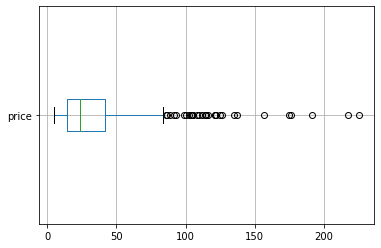

In [50]:
#Box Plot / Boîte à moustaches
#montre les valeurs extrêmes et la symétrie, la dispersion ou la centralité de la distribution des valeurs 
#associées à la variable 'price'
#pas de symétrie dans la distribution
df_final.boxplot(column='price', vert=False)

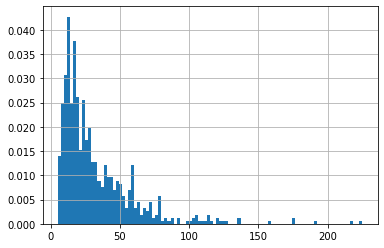

In [51]:
#histogramme pour la variable quantitative continue price qui montre les valeurs extremes à droite 
#l'histogramme est étalé à droite et presente donc une asymétrie 
df_final['price'].hist(density=True, bins=100)
plt.show()

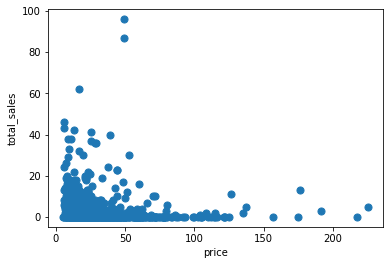

In [52]:
#Diagramme de dispersion / Nuage de points mettant en relief la relation entre les 2 variables price et total_sales
#montre la concentration de la plupart des prix à gauche et les valeurs extremes à droite
#plus les prix sont élevés, moins il y a de ventes des produits
df_final.plot.scatter( x="price", y="total_sales", s = 50)